## Least-sqaured regression

### Imports

In [341]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-ticks")
from numpy.random import randn

### Values

In [342]:
n = 200 # Number of points
sigma = 2
sigma2 = 2*sigma**2
lam = 0.000001

# Approximation parameters
m = 30
w = randn(m) / sigma
b = np.random.rand(m)*2*np.pi

# Example functions
x = randn(n)/2
y=np.cos(x) + randn(n) # randn(n) is noise

x_sort = np.sort(x)

### Gaussian kernel

In [343]:
def k_gauss(x, z): 
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k

def K_gauss(x, y, n):
    Kxy = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            Kxy[i, j] = k_gauss(x[i], y[j])
    return Kxy

#### Alpha

In [344]:
def alpha_gauss(x, y, n):
    K = K_gauss(x, x, n)
    return np.linalg.inv(K + lam*np.eye(n)) @ y

alpha_ = alpha_gauss(x, y, n)

#### Estimated function

In [345]:
def function_gauss(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        sum = 0
        for j in range(n):
            sum = sum + alpha[j] * k_gauss(x[j], x_sort[i])
            f[i] = sum
    return f

func = function_gauss(x, n, alpha_)

#### Plot

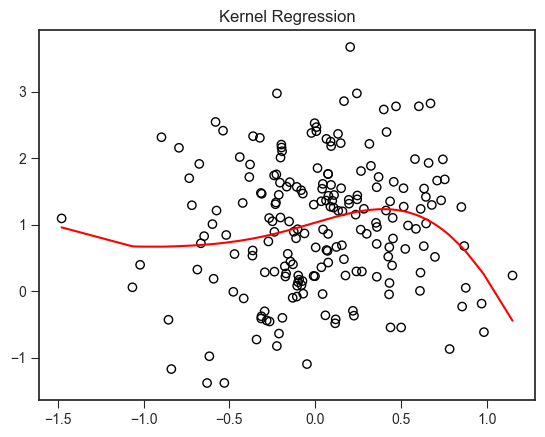

In [346]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func, c="r", label="with Gaussian")
plt.title("Kernel Regression")
plt.show()

## Random Fourier Features

### Approximation 1

In [347]:
# Feature vector
def psi(x, w, b):
    return np.sqrt(2)*np.cos(w*x + b)

def k_approx1(x_i, z_i, w, b, m):
    return 1/m * np.sum(psi(x_i, w, b) * psi(z_i, w, b))

# Not in use
def K_approx1(x, z, w, b, m):
    K = np.zeros((n ,m))
    for i in range(n):
        for j in range(m):
            K[i, j] = k_approx1(x[i], z[j], w, b, m)
    return K

K_ = K_approx1(x, x, w, b, m)

#### Alpha

In [348]:
def alpha_approx1(x, y, lam, w, b, m):
    K = np.zeros((n ,m))
    for i in range(n):
        K[i, :] = psi(x[i], w, b)
    return np.linalg.inv(K.T @ K + lam*np.eye(m)) @ K.T @ y

alpha_approx = alpha_approx1(x, y, lam, w, b, m)

#### Estimated function

In [349]:
def function_approx1(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*psi(x_sort[i], w, b))
    return f

func_approx1 = function_approx1(x, n, alpha_approx)

#### Plot

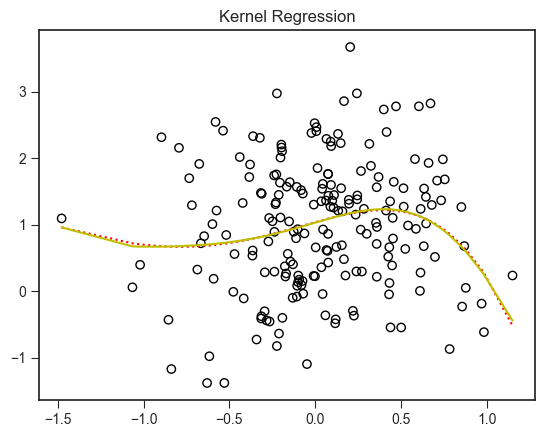

In [350]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx1, c="r", label="with Approximation 1", ls = ":")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.show()

### Approximation 2

In [351]:
def psi_cos(x, w, m):
    return 1/np.sqrt(m) * np.cos(w*x)

def psi_sin(x, w, m):
    return 1/np.sqrt(m) * np.sin(w*x)

def k_approx2(x, y, w, m):
    return np.sum(psi_cos(x, w, m)*psi_cos(y, w, m)) + np.sum(psi_cos(x, w, m)*psi_cos(y, w, m))

# Not in use
def K_approx2(x, y, w, n, m):
    K = np.zeros((n, m))
    for i in range(n):
        for j in range(m): 
            K[i, j] = k_approx2(x, y, w, m)
    return K

### Alpha

In [352]:
def alpha_approx2(x, y, w, n, m):
    K = np.zeros((n, m))
    for i in range(n):
        K[i, :] = psi_cos(x[i], w, m) + psi_sin(x[i], w, m)
    print(K)
    alpha = np.linalg.inv(K.T @ K + lam*np.eye(m)) @ K.T @ y
    return alpha

alpha_2 = alpha_approx2(x, y, w, n, m)
alpha_2

[[0.15673688 0.07262468 0.25337382 ... 0.10202555 0.2257108  0.02295018]
 [0.18573455 0.19415899 0.16785916 ... 0.19142956 0.17578491 0.19847484]
 [0.1777274  0.16372979 0.20256539 ... 0.16844436 0.19230281 0.15589847]
 ...
 [0.19206387 0.21533088 0.13447071 ... 0.20815124 0.16107381 0.2258713 ]
 [0.18891903 0.20517784 0.15170627 ... 0.20002463 0.16857352 0.21306965]
 [0.18126909 0.17762012 0.18826499 ... 0.17883117 0.18527398 0.17564307]]


array([-11.21783723,  54.11892609,  81.51817551,  20.57951081,
       -20.46579746, -25.29662686, -30.72077876,  34.75844165,
       -30.74436878,  48.73414735, -26.34670173,   1.18040196,
        31.41485131, -29.39714643, -51.30800688,   5.36323752,
       -17.60299547, -30.73359065, -15.10232503,  54.14877907,
        19.78774013,  -2.41576389, -16.87198011,   6.17465926,
        18.55196225, -18.12909097, -36.16463226,  45.08566517,
        -2.28652439, -50.91300489])

#### Estimated function

In [353]:
def function_approx2(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*(psi_cos(x_sort[i], w, m) + psi_sin(x_sort[i], w, m)))
    return f

func_approx2 = function_approx2(x, n, alpha_2)
func_approx2

array([ 0.96392002,  0.72989472,  0.71224426,  0.67676474,  0.66985212,
        0.66774813,  0.66422129,  0.66432518,  0.66527283,  0.66841404,
        0.66988316,  0.67128119,  0.67455308,  0.67795681,  0.68092209,
        0.68534988,  0.6871665 ,  0.6903469 ,  0.69199176,  0.70434   ,
        0.70707672,  0.71117059,  0.72815977,  0.73120615,  0.7455402 ,
        0.75406926,  0.75709667,  0.77460778,  0.77709746,  0.7849211 ,
        0.78574372,  0.78708713,  0.79911877,  0.81102934,  0.81467261,
        0.81584978,  0.8168632 ,  0.8178018 ,  0.8286003 ,  0.8292463 ,
        0.83624126,  0.84294584,  0.84599168,  0.84769662,  0.85905881,
        0.86569031,  0.86681083,  0.86683173,  0.87087864,  0.87309565,
        0.87477261,  0.87685367,  0.87708978,  0.88459758,  0.88553201,
        0.88952072,  0.89168871,  0.89182462,  0.89537357,  0.89610502,
        0.89844489,  0.89969071,  0.90999669,  0.91236652,  0.91536961,
        0.91794417,  0.92241568,  0.92826169,  0.93099012,  0.93

#### Plot

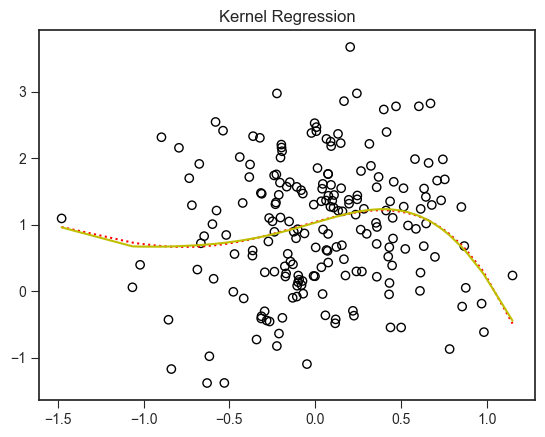

In [354]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx2, c="r", label="with Approx 2", ls = ":")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.show()

## All plots

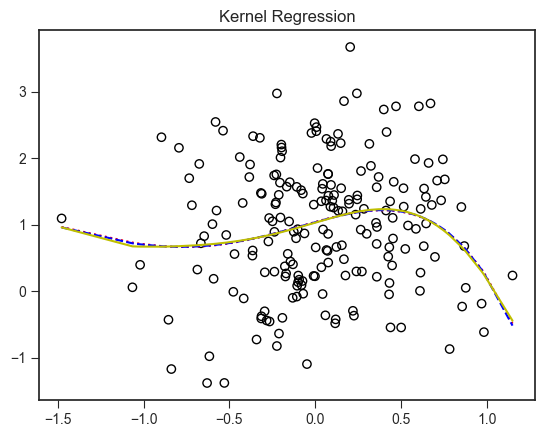

In [355]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx2, c="r", label="with Approximation 2", ls = ":")
plt.plot(x_sort, func_approx1, c="b", label="with Approximation 1", ls = "--")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.show()